In [3]:
import torch
import botorch
import gpytorch

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel
from gpytorch.constraints.constraints import GreaterThan
from gpytorch.likelihoods import GaussianLikelihood

from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double # double == float64

# isn't this easier?
# https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(dtype)

# torch.set_default_device(device) # similarly

import numpy as np
import matplotlib.pyplot as plt

from function_samples_dataset import GaussianProcessRandomDataset, ListMapFunctionSamplesDataset, LazyMapFunctionSamplesDataset
from acquisition_dataset import FunctionSamplesAcquisitionDataset
from predict_EI_simple import calculate_EI_GP
from utils import get_uniform_randint_generator, loguniform_randint, get_loguniform_randint_generator, pad_tensor, remove_priors


In [5]:
from botorch.models.gp_regression import SingleTaskGP

dim = 1
train_X = torch.rand(10, dim, dtype=torch.float64) * 2.3 - 4.9
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True) * 3.2 + 6.3

gp = SingleTaskGP(train_X, train_Y)
gp.state_dict()

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([8.3760]), std = tensor([1.2588])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


OrderedDict([('likelihood.noise_covar.raw_noise', tensor([2.0000])),
             ('likelihood.noise_covar.noise_prior.concentration',
              tensor(1.1000)),
             ('likelihood.noise_covar.noise_prior.rate', tensor(0.0500)),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(0.0001)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(0.)),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.lengthscale_prior.concentration',
              tensor(3.)),
             ('covar_module.base_kernel.lengthscale_prior.rate', tensor(6.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound'

tensor([-1.3039,  0.8990], grad_fn=<AddBackward0>)
tensor([-1.3039,  0.8990], grad_fn=<AddBackward0>)


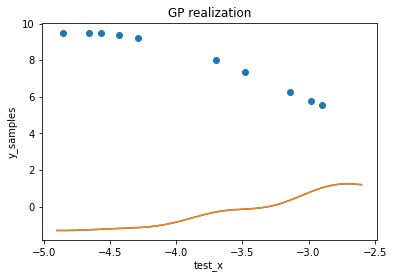

In [3]:
import torch
torch.set_default_dtype(torch.float64)
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.sampling.pathwise import draw_kernel_feature_paths
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from random_gp_function import RandomGPFunction
from utils import get_gp
import matplotlib.pyplot as plt


dim = 1
train_X = torch.rand(10, dim, dtype=torch.float64) * 2.3 - 4.9
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True) * 3.2 + 6.3
model = get_gp(
    dimension=dim,
     # train_X, train_Y,
     # covar_module=ScaleKernel(RBFKernel(ard_num_dims=dim)),
    #  outcome_transform=Standardize(m=1),
    #  input_transform=Normalize(d=dim),/
     observation_noise=False)
model.eval()
# model.train_inputs = None
# model.train_targets = None

# print(model.covar_module.base_kernel.lengthscale)
# model.initialize(**{'covar_module.base_kernel.lengthscale': 0.05})
# model.covar_module.base_kernel.lengthscale = 0.1
# print(model.covar_module.base_kernel.lengthscale)

sample_path = draw_kernel_feature_paths(model, sample_shape=torch.Size(), num_features=4096)
# sample_path = RandomGPFunction(model, observation_noise=False)

test_x = torch.linspace(-4.9, -4.9+2.3, 200).unsqueeze(-1)
test_y = sample_path(test_x).detach()
plt.plot(test_x.squeeze(-1), test_y)

print(sample_path(torch.tensor([[-4.9], [0.1]], dtype=torch.float64)))

# model.initialize(**{'covar_module.base_kernel.lengthscale': 0.06})

# print(sample_path(torch.tensor([[0.0, 0.0], [1.2, 3.4]], dtype=torch.float64)))
# print(sample_path(torch.tensor([[1.2, 3.4]], dtype=torch.float64)))

test_x = torch.linspace(-4.9, -4.9+2.3, 200).unsqueeze(-1)
test_y = sample_path(test_x).detach()

# print(sample_path(torch.tensor([[-4.9], [0.1]], dtype=torch.float64)))
print(sample_path(torch.tensor([[-4.9+1e-4], [0.1]], dtype=torch.float64)))

plt.plot(test_x.squeeze(-1), test_y)
plt.scatter(train_X.squeeze(-1), train_Y.squeeze(-1))
plt.xlabel('test_x')
plt.ylabel('y_samples')
plt.title('GP realization')
plt.show()

In [1]:
from utils import dict_product, combine_dicts

# Test combine_dicts
dict_list = [{'a': 1, 'b': 2}, {'c': 3, 'd': 4}, {'b': 5, 'e': 6}]
combined = combine_dicts(dict_list)
print("Combined dictionaries:", combined)

# Test dict_product
list1 = [{'x': 1}, {'x': 2}]
list2 = [{'y': 'a'}, {'y': 'b'}]
list3 = [{'z': True}, {'z': False}]

product = dict_product(list1, list2, list3)
print("\nDictionary product:")
for item in product:
    print(item)

# Test with overlapping keys
list4 = [{'a': 1, 'b': 2}, {'a': 3, 'c': 4}]
list5 = [{'b': 5, 'd': 6}, {'c': 7, 'e': 8}]

product_overlap = dict_product(list4, list5)
print("\nDictionary product with overlapping keys:")
for item in product_overlap:
    print(item)

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

Combined dictionaries: {'a': 1, 'b': 5, 'c': 3, 'd': 4, 'e': 6}

Dictionary product:
{'x': 1, 'y': 'a', 'z': True}
{'x': 1, 'y': 'a', 'z': False}
{'x': 1, 'y': 'b', 'z': True}
{'x': 1, 'y': 'b', 'z': False}
{'x': 2, 'y': 'a', 'z': True}
{'x': 2, 'y': 'a', 'z': False}
{'x': 2, 'y': 'b', 'z': True}
{'x': 2, 'y': 'b', 'z': False}

Dictionary product with overlapping keys:
{'a': 1, 'b': 5, 'd': 6}
{'a': 1, 'b': 2, 'c': 7, 'e': 8}
{'a': 3, 'c': 4, 'b': 5, 'd': 6}
{'a': 3, 'c': 7, 'e': 8}


In [8]:
import itertools
list(itertools.product(*list4))

[('a', 'a'), ('a', 'c'), ('b', 'a'), ('b', 'c')]

In [15]:
x = [3.4, 23, 'bi']
import numpy as np
np.array(x)

array(['3.4', '23', 'bi'], dtype='<U32')

In [17]:
set((1,2))

{1, 2}

In [4]:
from botorch.test_functions import Hartmann
from utils import remove_priors, add_priors
objective = Hartmann(negate=True)
x = torch.rand(20, 6, device=device, dtype=torch.float64)
y = objective(x).unsqueeze(-1)  # add output dimension

model = SingleTaskGP(x, y)

print("initial model:")
print(model)

print("\nmodel priors:")
print(list(model.named_priors()))

named_priors_tuple_list = remove_priors(model)

print("\nmodel with priors removed:")
print(model)
print("\nmodel priors:")
print(list(model.named_priors()))

add_priors(named_priors_tuple_list)

print("\nmodel with priors added back:")
print(model)
print("\nmodel priors:")
print(list(model.named_priors()))

[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([2.0000], requires_grad=True)), ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0., 0.]], requires_grad=True))]


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2111]), std = tensor([0.2896])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [38]:
from botorch.utils.sampling import draw_sobol_samples
dim = 2
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
n_initial_samples = 6
draw_sobol_samples(bounds=bounds, n=5, q=n_initial_samples).shape
# torch.rand(n_initial_samples)

torch.Size([5, 6, 2])

In [7]:
from botorch.test_functions import Hartmann
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

objective = Hartmann(negate=True)
x = torch.rand(20, 6, device=device, dtype=torch.float64)
y = objective(x).unsqueeze(-1)  # add output dimension


best = [y.max()] # This will store the best value

n_dims = x.shape[-1]
bounds = torch.tensor([[0.0] * n_dims, [1.0] * n_dims])


kernel = ScaleKernel(
    base_kernel=RBFKernel(
        ard_num_dims=n_dims,
    )
)

# model = SingleTaskGP(x, y, torch.full_like(y, 1e-5),
#                          covar_module=kernel,
#                         )
# print(list(model.named_parameters()))
# mll = ExactMarginalLogLikelihood(model.likelihood, model)
# fit_gpytorch_mll(mll)
# print(list(model.named_parameters()))

import copy
model = SingleTaskGP(x, y, torch.full_like(y, 1e-5),
                         covar_module=kernel,
                        )
print(model.training, "TRAINING")
print("INITIAL:", list(model.named_parameters()))
model_fit = copy.deepcopy(model)
mll = ExactMarginalLogLikelihood(model_fit.likelihood, model_fit)
fit_gpytorch_mll(mll)
print(model.training, "TRAINING")
print("FITTING")
print("FIT:", list(model_fit.named_parameters()))
print("INITIAL:", list(model.named_parameters()))


BoTorch_EI = ExpectedImprovement(model=model, best_f=y.max())
new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=bounds,
        q=1,
        num_restarts=100,
        raw_samples=500,
        options={},
    )
print(new_point)
print(new_point_EI)

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1981]), std = tensor([0.2508])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


True TRAINING
INITIAL: [('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0., 0.]], requires_grad=True))]
True TRAINING
FITTING
FIT: [('mean_module.raw_constant', Parameter containing:
tensor(0.1712, requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(-3.0060, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-5.7663e-01,  4.9056e+03, -1.0409e+00, -1.4963e+00,  2.1436e+03,
          3.8301e+03]], requires_grad=True))]
INITIAL: [('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0., 0.]], 

In [54]:
objective = Hartmann(negate=True)
x = torch.rand(20, 6, device=device, dtype=torch.float64)
y = objective(x).unsqueeze(-1)  # add output dimension
n_dims = x.shape[-1]

x2 = torch.rand(20, 6, device=device, dtype=torch.float64)
y2 = objective(x2).unsqueeze(-1)  # add output dimension

model = SingleTaskGP(x, y, torch.full_like(y, 1e-5),
                         covar_module=ScaleKernel(base_kernel=RBFKernel(ard_num_dims=n_dims)))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
print("FIT1:", list(model.named_parameters()))

model.set_train_data(x2, y2.squeeze(-1), strict=False)
fit_gpytorch_mll(mll)
print("FIT2 with warm start after initial fit:", list(model.named_parameters()))

model2 = SingleTaskGP(x2, y2, torch.full_like(y, 1e-5),
                         covar_module=ScaleKernel(base_kernel=RBFKernel(ard_num_dims=n_dims)))
mll2 = ExactMarginalLogLikelihood(model2.likelihood, model2)
fit_gpytorch_mll(mll2)
print("FIT2 with no warm start:", list(model2.named_parameters()))

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1798]), std = tensor([0.2306])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


FIT1: [('mean_module.raw_constant', Parameter containing:
tensor(0.1722, requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(-3.0826, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-1.8575e+00,  1.1294e+03,  1.0966e+04, -1.7604e+00,  2.8340e-03,
          1.9293e-01]], requires_grad=True))]
FIT2 with warm start after initial fit: [('mean_module.raw_constant', Parameter containing:
tensor(0.3120, requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(-1.6184, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[ 1.0885e+04,  1.1294e+03,  1.0966e+04, -2.2300e+00, -1.7695e+00,
          4.1100e+03]], requires_grad=True))]
FIT2 with no warm start: [('mean_module.raw_constant', Parameter containing:
tensor(0.3790, requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(-1.3248, requires_grad=True)), ('covar_m

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2602]), std = tensor([0.4106])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [61]:
objective = Hartmann(negate=True)
x = torch.rand(20, 6, device=device, dtype=torch.float64)
y = objective(x).unsqueeze(-1)  # add output dimension
n_dims = x.shape[-1]

In [10]:
from botorch.models.transforms.outcome import Standardize

model = SingleTaskGP(x, y, outcome_transform=Standardize(m=1))
if hasattr(model, "outcome_transform"):
    print(model.outcome_transform.means, model.outcome_transform.stdvs)
    print(f"{model.training=}, {model.outcome_transform.training=}")

mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
if hasattr(model, "outcome_transform"):
    print(model.outcome_transform.means, model.outcome_transform.stdvs)
    print(f"{model.training=}, {model.outcome_transform.training=}")
print(list(model.named_parameters()))

tensor([[0.1981]]) tensor([[0.2508]])
model.training=True, model.outcome_transform.training=True
tensor([[0.1981]]) tensor([[0.2508]])
model.training=False, model.outcome_transform.training=False
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0162], requires_grad=True)), ('mean_module.raw_constant', Parameter containing:
tensor(-0.0500, requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(0.1866, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-0.7757, -0.1961, -0.9707, -0.9451, -0.6710, -0.3694]],
       requires_grad=True))]


In [12]:
from utils import calculate_batch_improvement
import torch

# Example Usage
batch_size = 4
max_n_hist = 10
max_n_cand = 5

# Example y_hist_batch with padding and hist_mask
y_hist_batch = torch.randn(batch_size, max_n_hist, 1)
hist_mask = (torch.rand(batch_size, max_n_hist, 1) > 0.1)  # Random hist_mask for example
print(hist_mask)

# Example y_cand_batch with padding and cand_mask
y_cand_batch = torch.randn(batch_size, max_n_cand, 1)
cand_mask = (torch.rand(batch_size, max_n_cand, 1) > 0.1)  # Random cand_mask for example
print(cand_mask)

improvement_values_batch = calculate_batch_improvement(y_hist_batch, y_cand_batch, hist_mask, cand_mask)
print(improvement_values_batch)

tensor([[[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [False],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         [False],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True]]])
tensor([[[False],
         [ True],
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         [ True],
         [ True]

In [18]:
import re

def sanitize_file_name(file_name: str) -> str:
    # Define a dictionary of characters to replace
    replacements = {
        '/': '_',
        '\\': '_',
        ':': '_',
        '*': '_',
        '?': '_',
        '"': '_',
        '<': '_',
        '>': '_',
        '|': '_',
    }

    # Replace the characters based on the replacements dictionary
    sanitized_name = ''.join(replacements.get(c, c) for c in file_name)

    # Remove characters that are non-printable or not allowed
    sanitized_name = re.sub(r'[^\x20-\x7E]', '', sanitized_name)

    # Remove all whitespace characters
    sanitized_name = re.sub(r'\s+', '', sanitized_name)

    return sanitized_name

# Example usage
proposed_file_name = "example/illegal\\name:*?\"<>|.txt with spac\nfuck\nes"
sanitized_file_name = sanitize_file_name(proposed_file_name)
print(sanitized_file_name)  # Output: example_illegal_name_.txt_with_spaces


example_illegal_name_______.txtwithspacfuckes


In [2]:
from botorch.models.transforms.outcome import Power
from utils import Exp

dataset = GaussianProcessRandomDataset(
    n_datapoints=3, observation_noise=False,
    dimension=2, randomize_params=True)
# u = next(dataset)
# a = u.model
# v = next(dataset)
# b = v.model

q = dataset.fix_samples(1, lazy=False)
print(q[0]._model is dataset.model_sampler._models[0])
print(q.model_sampler is dataset.model_sampler)
print(q.model_sampler._models is dataset.model_sampler._models)
print(q.model_sampler._models[0] is dataset.model_sampler._models[0])
# print(q[0]._model)
# print(dataset.model_sampler._models[0])

# print(list(dataset.model_sampler._models[0].named_parameters()))
for w in q:
    print(w)

print("\n-----Transforming outcomes with Exp------")
q = q.transform_outcomes(Exp())

for w in q:
    print(w)

print("\n-----Standardizing outcomes------")
q = q.standardize_outcomes()

for w in q:
    print(w.model_params['outcome_transform'])
    print()

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


Saving realizations from GaussianProcessRandomDataset into ListMapFunctionSamplesDataset


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

True
True
True
True
FunctionSamplesItem(tensor([[0.8516, 0.2163],
        [0.5338, 0.5516],
        [0.1333, 0.9557]]), tensor([[0.5394],
        [1.2450],
        [3.9864]]), SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(0.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
))

-----Transforming outcomes with Exp------
FunctionSamplesItem(tensor([[0.8516, 0.2163],
        [0.5338, 0.5516],
        [0.1333, 0.9557]]), tensor([[ 1.7150],
        [ 3.4729],
        [53.8614]]), SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(0.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (cova

In [6]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize


train_X = torch.rand(20, 2, dtype=torch.float64)
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
outcome_transform = Standardize(m=1)
inferred_noise_model = SingleTaskGP(
     train_X, train_Y, outcome_transform=outcome_transform,
 )
# list(inferred_noise_model.named_parameters())
del getattr(inferred_noise_model, "outcome_transform")
inferred_noise_model.outcome_transform

SyntaxError: cannot delete function call (1259788926.py, line 12)

In [76]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize

train_X = torch.rand(10, 2, dtype=torch.float64) * 2.3 - 4.9
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True) * 3.2 + 6.3
model = SingleTaskGP(
     train_X, train_Y,
     outcome_transform=Standardize(m=1),
     input_transform=Normalize(d=2))

print(f"{model.training=}")
print(f"{model._has_transformed_inputs=}")
print(f"{model.train_inputs=}")
print(f"{model.train_targets=}")

print("Calling model on some data")
test_X = torch.rand(4, 2, dtype=torch.float64) * 2.3 - 4.9
posterior = model.posterior(test_X, observation_noise=False)

print(f"{model.training=}")
print(f"{model._has_transformed_inputs=}")
print(f"{model.train_inputs=}")

print("Conditioning model on observations")
new_X = torch.rand(6, 2, dtype=torch.float64) * 2.3 - 4.9
new_Y = torch.sin(new_X).sum(dim=1, keepdim=True) * 3.2 + 6.3
conditioned_model = model.condition_on_observations(new_X, new_Y)

print(f"{conditioned_model.training=}")
print(f"{conditioned_model._has_transformed_inputs=}")
print(f"{conditioned_model.train_inputs=}")
print(f"{conditioned_model.train_targets=}")
print(f"{conditioned_model._original_train_inputs=}")

print("Putting conditioned_model into train mode")
conditioned_model.train()
print(f"{conditioned_model.train_inputs=}")

model.training=True
model._has_transformed_inputs=False
model.train_inputs=(tensor([[-3.3207, -4.5048],
        [-3.3313, -3.1436],
        [-2.8605, -4.2584],
        [-3.2794, -4.7504],
        [-4.0462, -3.2497],
        [-3.1691, -4.7543],
        [-3.8687, -3.3300],
        [-3.3353, -4.5721],
        [-4.4484, -4.3761],
        [-3.5142, -3.6537]], dtype=torch.float64),)
model.train_targets=tensor([ 0.3948, -1.7935, -0.8180,  0.3494, -0.2001,  0.1001, -0.2954,  0.4537,
         2.0997, -0.2908], dtype=torch.float64)
Calling model on some data
model.training=False
model._has_transformed_inputs=True
model.train_inputs=(tensor([[0.7102, 0.1549],
        [0.7035, 1.0000],
        [1.0000, 0.3079],
        [0.7362, 0.0025],
        [0.2533, 0.9342],
        [0.8057, 0.0000],
        [0.3650, 0.8843],
        [0.7010, 0.1131],
        [0.0000, 0.2348],
        [0.5883, 0.6833]], dtype=torch.float64),)
Conditioning model on observations
conditioned_model.training=False
conditioned_model

In [2]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.sampling.normal import SobolQMCNormalSampler

train_X = torch.rand(10, 2, dtype=torch.float64) * 2.3 - 4.9
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True) * 3.2 + 6.3
model = SingleTaskGP(
     train_X, train_Y,
     outcome_transform=Standardize(m=1),
     input_transform=Normalize(d=2))

print(f"{model.training=}")
print(f"{model._has_transformed_inputs=}")
print(f"{model.train_inputs=}")
print(f"{model.train_targets=}")

print("Conditioning model with fantasize")
test_X = torch.rand(4, 2, dtype=torch.float64) * 2.3 - 4.9
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([]))
conditioned_model = model.fantasize(test_X, sampler)

print(f"{conditioned_model.training=}")
print(f"{conditioned_model._has_transformed_inputs=}")
print(f"{conditioned_model.train_inputs=}")
print(f"{conditioned_model.train_targets=}")
print(f"{conditioned_model._original_train_inputs=}")

print("Putting conditioned_model into train mode")
conditioned_model.train()
print(f"{conditioned_model.train_inputs=}")

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

model.training=True
model._has_transformed_inputs=False
model.train_inputs=(tensor([[-3.3326, -3.3023],
        [-4.8419, -3.7348],
        [-3.6567, -2.6734],
        [-3.6973, -4.7147],
        [-3.3038, -4.8252],
        [-3.8895, -3.7252],
        [-2.9836, -4.2437],
        [-2.9657, -2.8881],
        [-4.5955, -2.6542],
        [-3.7737, -3.0240]], dtype=torch.float64),)
model.train_targets=tensor([-0.5637,  1.2837, -1.0384,  1.2481,  0.6752,  0.7921,  0.0285, -1.7573,
        -0.2946, -0.3735], dtype=torch.float64)
Conditioning model with fantasize
conditioned_model.training=False
conditioned_model._has_transformed_inputs=True
conditioned_model.train_inputs=[tensor([[0.8044, 0.7015],
        [0.0000, 0.5023],
        [0.6317, 0.9911],
        [0.6101, 0.0509],
        [0.8198, 0.0000],
        [0.5076, 0.5067],
        [0.9905, 0.2678],
        [1.0000, 0.8923],
        [0.1314, 1.0000],
        [0.5693, 0.8297],
        [0.8321, 0.0569],
        [0.9675, 0.3989],
        [0.655

In [6]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from utils import *

train_X = torch.rand(10, 2, dtype=torch.float64) * 2.3 - 4.9
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True) * 3.2 + 6.3
print(train_Y)
model = SingleTaskGP(
     train_X, train_Y,
     outcome_transform=Standardize(m=1),
     input_transform=Normalize(d=2))
print(model._original_train_inputs)
# model.eval()
print(f"{model.input_transform.training=}")
print(f"{model.outcome_transform.training=}")
print(f"{model.outcome_transform._is_trained=}")

print(f"{model.training=}")
print(f"{model._has_transformed_inputs=}")
print(f"{model.train_inputs=}")
print(f"{model.train_targets=}")

# print("Calling model on some data")
# test_X = torch.rand(4, 2, dtype=torch.float64) * 2.3 - 4.9
# posterior = model.posterior(test_X, observation_noise=False)
# print(f"{model.input_transform.training=}")
# print(f"{model.outcome_transform.training=}")
# print(f"{model.training=}")
# print(f"{model._has_transformed_inputs=}")
# print(f"{model.train_inputs=}")

if hasattr(model, "outcome_transform"):
    print(f"{model.outcome_transform.means=}")
    print(f"{model.outcome_transform.stdvs=}")

print("Setting the train data")
model.eval()
new_X = torch.rand(6, 2, dtype=torch.float64) * 2.3 - 4.9
new_Y = torch.sin(new_X).sum(dim=1, keepdim=True) * 3.2 + 6.3
model.set_train_data_with_transforms(new_X, new_Y, strict=False, train=True)


if hasattr(model, "outcome_transform"):
    print(f"{model.outcome_transform.means=}")
    print(f"{model.outcome_transform.stdvs=}")
    print(f"{model.outcome_transform.training=}")
    print(f"{model.outcome_transform._is_trained=}")

# model.set_train_data(new_X, new_Y, strict=False)



print(f"{model.training=}")
print(f"{model._has_transformed_inputs=}")
print(f"{model.train_inputs=}")
print(f"{model.train_targets=}")

print("Putting in eval mode")
model.eval()

print(f"{model.training=}")
print(f"{model._has_transformed_inputs=}")
print(f"{model.train_inputs=}")
print(f"{model._original_train_inputs=}")

tensor([[ 6.9473],
        [ 3.7036],
        [ 8.6021],
        [ 7.4870],
        [10.6643],
        [ 7.5800],
        [ 6.7033],
        [12.0351],
        [10.8833],
        [10.0405]])
None
model.input_transform.training=True
model.outcome_transform.training=True
model.outcome_transform._is_trained=tensor(True)
model.training=True
model._has_transformed_inputs=False
model.train_inputs=(tensor([[-2.6268, -3.9095],
        [-2.7134, -2.7343],
        [-4.2767, -2.9533],
        [-2.6951, -4.0735],
        [-4.1204, -3.7049],
        [-2.9049, -3.8290],
        [-3.0950, -3.3150],
        [-4.2788, -4.2275],
        [-3.8524, -4.0360],
        [-3.8234, -3.7105]]),)
model.train_targets=tensor([-0.6097, -1.9129,  0.0552, -0.3928,  0.8838, -0.3554, -0.7077,  1.4346,
         0.9718,  0.6332])
model.outcome_transform.means=tensor([[8.4646]])
model.outcome_transform.stdvs=tensor([[2.4889]])
Setting the train data
model.outcome_transform.means=tensor([[9.7376]])
model.outcome_transform.s

In [99]:
train_X = torch.rand(3, 1, 5, 7)
num_outputs = 4
train_X = train_X.unsqueeze(-3).expand(
        train_X.shape[:-2] + torch.Size([num_outputs]) + train_X.shape[-2:]
    ).shape


torch.Size([3, 1, 4, 5, 7])

In [66]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.acquisition.analytic import LogNoisyExpectedImprovement
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel

train_X = torch.rand(10, 2, dtype=torch.float64) * 2.3 - 4.9
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
train_Yvar = torch.full_like(train_Y, 1e-3)

model = SingleTaskGP(
     train_X, train_Y,
     outcome_transform=Standardize(m=1),
     input_transform=Normalize(d=2),
     train_Yvar=train_Yvar)

# model = SingleTaskGP(
#      train_X, train_Y,
#      covar_module=ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1])),
#      train_Yvar=train_Yvar)


LogNEI = LogNoisyExpectedImprovement(model, train_X)


# print(model.state_dict())
# print(f"{model.training=}")
# print(f"{model._has_transformed_inputs=}")
# print(f"{model.train_inputs=}")

# print(LogNEI.model)
# nei = LogNEI(test_X)



RuntimeError: Error(s) in loading state_dict for SingleTaskGP:
	Unexpected key(s) in state_dict: "outcome_transform.means", "outcome_transform.stdvs", "outcome_transform._stdvs_sq", "outcome_transform._is_trained", "input_transform._coefficient", "input_transform._offset". 

In [100]:
train_X = torch.rand(10, 2, dtype=torch.float64) * 2.3 - 4.9
train_Y = torch.sin(train_X).sum(dim=1, keepdim=False)

model = SingleTaskGP(
     train_X, train_Y)

BotorchTensorDimensionError: An explicit output dimension is required for targets. Expected Y with dimension 2 (got Y.dim()=1).

In [23]:
from functools import partial

class MyClass:
    @staticmethod
    def test(bla, bd):
        return bla, bd

# Create the partial function using the static method from the class
partial_test = partial(MyClass.test, 3)

# Call the partial function
result = partial_test(bd=5)
print(result)  # Output: (3, 5)


(3, 5)


In [2]:
from random_gp_function import RandomGPFunction

model = GaussianProcessRandomDataset(
    n_datapoints=1, observation_noise=False,
    dimension=1, randomize_params=True)._model_sampler.sample()
print(model.covar_module.base_kernel.lengthscale)
f = RandomGPFunction(model, observation_noise=False)
f(torch.tensor([[1.3], [0.1]]))

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


tensor([[0.2828]], grad_fn=<SoftplusBackward0>)


tensor([-0.1478,  5.0348])

In [3]:
from function_samples_dataset import GaussianProcessRandomDataset
from botorch.models.transforms.outcome import Power

gp_dataset = GaussianProcessRandomDataset(
    dataset_size=15,
    n_datapoints=7, observation_noise=False, dimension=3, randomize_params=True)
lazy_dataset = gp_dataset.fix_samples(lazy=True)
print("                lazy_dataset[0].y_values:", lazy_dataset[0].y_values)
print("            lazy_dataset evaluated items:", [int(x is not None) for x in lazy_dataset._data])

square_transform = Power(2)
transformed_lazy_dataset = lazy_dataset.transform_outcomes(square_transform)
print("Made transformed dataset")
print("transformed_lazy_dataset evaluated items:", [int(x is not None) for x in transformed_lazy_dataset._data])
print("    transformed_lazy_dataset[0].y_values:", transformed_lazy_dataset[0].y_values)

print("                lazy_dataset[2].y_values:", lazy_dataset[2].y_values)
print("            lazy_dataset evaluated items:", [int(x is not None) for x in lazy_dataset._data])
print("transformed_lazy_dataset evaluated items:", [int(x is not None) for x in transformed_lazy_dataset._data])
print("    transformed_lazy_dataset[2].y_values:", transformed_lazy_dataset[2].y_values)
print("transformed_lazy_dataset evaluated items:", [int(x is not None) for x in transformed_lazy_dataset._data])


print("    transformed_lazy_dataset[-1].y_values:", transformed_lazy_dataset[-1].y_values)
print("            lazy_dataset evaluated items:", [int(x is not None) for x in lazy_dataset._data])
print("transformed_lazy_dataset evaluated items:", [int(x is not None) for x in transformed_lazy_dataset._data])

print("            lazy_dataset.data_is_loaded():", lazy_dataset.data_is_loaded())
print("transformed_lazy_dataset.data_is_loaded():", transformed_lazy_dataset.data_is_loaded())


print("Evaluating all items")
for i in range(len(lazy_dataset)):
    lazy_dataset[i]
print("            lazy_dataset evaluated items:", [int(x is not None) for x in lazy_dataset._data])
print("transformed_lazy_dataset evaluated items:", [int(x is not None) for x in transformed_lazy_dataset._data])

print("            lazy_dataset.data_is_loaded():", lazy_dataset.data_is_loaded())
print("transformed_lazy_dataset.data_is_loaded():", transformed_lazy_dataset.data_is_loaded())

transformed_gp_dataset = gp_dataset.transform_outcomes(square_transform)
print("transformed_gp_dataset:", transformed_gp_dataset)
print(next(iter(transformed_gp_dataset)))

                lazy_dataset[0].y_values: tensor([-0.9738, -8.1376, -5.5296,  1.1879, -3.6971, -3.0373,  0.1646])
            lazy_dataset evaluated items: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Made transformed dataset
transformed_lazy_dataset evaluated items: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    transformed_lazy_dataset[0].y_values: tensor([9.4822e-01, 6.6221e+01, 3.0576e+01, 1.4112e+00, 1.3668e+01, 9.2250e+00,
        2.7100e-02])
                lazy_dataset[2].y_values: tensor([-3.5430, 16.7996, -4.0666, -9.9256, -6.6908,  6.6380,  2.7995])
            lazy_dataset evaluated items: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
transformed_lazy_dataset evaluated items: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    transformed_lazy_dataset[2].y_values: tensor([ 12.5526, 282.2257,  16.5370,  98.5173,  44.7665,  44.0632,   7.8373])
transformed_lazy_dataset evaluated items: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    transformed_lazy_dataset[-1].y_values: 

In [4]:
f(torch.rand(4, 1))

False


tensor([-0.0432,  3.3867,  0.5625,  0.4680])

In [18]:
l=[1,2,[2,3]]
v = l.copy()
v[2][0] = 999
l, v

([1, 2, [999, 3]], [1, 2, [999, 3]])

In [4]:
# f.model._clear_cache()
print(f.model.prediction_strategy)

None


In [62]:
f.model.train_inputs[0].shape

torch.Size([50, 2])

In [27]:
a = torch.rand(5, 3)
a

tensor([[0.8689, 0.0254, 0.7824],
        [0.6075, 0.9092, 0.8809],
        [0.5809, 0.7194, 0.0127],
        [0.3432, 0.9606, 0.5279],
        [0.9266, 0.4266, 0.9935]])

In [19]:
f.model.train_inputs

[tensor([[ 1.3000,  4.2000],
         [ 0.1000, -0.1000],
         [ 0.0000,  3.2000]])]

In [8]:
f.model._clear_cache()

In [3]:
f(torch.tensor([0.0, 0.0]))

tensor(-0.1577)

In [4]:
f(torch.tensor([1.0, 0.0]))

tensor(-1.3204)

In [5]:
f(torch.tensor([[0.0, 0.0], [0.0, 0.0]]))

tensor([-0.1577, -0.1577])

In [9]:
f(torch.tensor([[0.0, -0.1]]))

tensor([0.0529])

In [11]:
f(torch.tensor([[0.0, -0.1],
                [0.0, 0.0],
                [8.3, 9.1],
                [0.0, 0.0],
                [-20.0, 50.3]]))

tensor([ 0.0529, -0.1577,  0.0159, -0.1577, -0.6754])

In [32]:
import torch
def get_unique(x):
    unique_indices_list = []
    for input_index in range(x.size(0)):
        input_point = x[input_index]
        
        found_matching_point = False
        for unique_point_index, original_indices in enumerate(unique_indices_list):
            unique_point = x[original_indices[0]]
            if torch.equal(input_point, unique_point):
                unique_indices_list[unique_point_index].append(input_index)
                found_matching_point = True
        
        if not found_matching_point:
            unique_indices_list.append([input_index])
    
    return x[[inds[0] for inds in unique_indices_list]], unique_indices_list

u = torch.tensor([
    [1.4, 8.9],
    [8.2, 3.1],
    [1.4, 8.9],
    [2.4, 1.1]
])
print(get_unique(u))


(tensor([[1.4000, 8.9000],
        [8.2000, 3.1000],
        [2.4000, 1.1000]]), [[0, 2], [1], [3]])


In [12]:
def mygen():
    while True:
        yield 1

print(mygen)
print(mygen())
print(iter(mygen()))

<function mygen at 0x7fd5c1b0b430>
<generator object mygen at 0x7fd5c1b64430>
<generator object mygen at 0x7fd5c1b64430>


In [8]:
from botorch.models.transforms.outcome import Standardize
s = Standardize(1)
s.eval()
s._is_trained, s.training

(tensor(False), False)

In [20]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x.detach()
y[0] = 10.
x, y

(tensor([10.,  2.,  3.], requires_grad=True), tensor([10.,  2.,  3.]))

In [23]:
x = torch.tensor([1.0], requires_grad=True)
type(x.item())

float

In [25]:
x.to(None) is x

True

In [27]:
a = (torch.tensor([1.2, 3.4]), torch.tensor(9.))
b = tuple(x for x in a)
a == b

True

In [4]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal

from dataset_with_models import RandomModelSampler, TupleWithModel

# Create a dummy SingleTaskGP model
class DummyGP(SingleTaskGP):
    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y)
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Create dummy data
train_X = torch.rand(10, 1)
train_Y = torch.sin(train_X * (2 * torch.pi)) + 0.2 * torch.randn(10, 1)

# Initialize dummy models
model1 = DummyGP(train_X, train_Y)
model2 = DummyGP(train_X, train_Y)
model3 = DummyGP(train_X, train_Y)

models = [model1, model2, model3]

# Initialize RandomModelSampler
sampler = RandomModelSampler(models)

# Example usage of TupleWithModel
tuple_with_model = TupleWithModel(1, 2, 3, model=model1)

print(tuple_with_model)
print(tuple_with_model.to_dict())


def test_tuple_with_model():
    # Create dummy data
    train_X = torch.rand(10, 1)
    train_Y = torch.sin(train_X * (2 * torch.pi)) + 0.2 * torch.randn(10, 1)

    # Initialize dummy models
    model1 = DummyGP(train_X, train_Y)
    model2 = DummyGP(train_X, train_Y)
    model3 = DummyGP(train_X, train_Y)

    models = [model1, model2, model3]
    sampler = RandomModelSampler(models)

    # Initialize TupleWithModel instances
    twm1 = TupleWithModel(1, 2, 3, model=model1)
    twm2 = TupleWithModel(1, 2, 3, model=model2)
    twm3 = TupleWithModel(4, 5, 6)

    assert TupleWithModel(*twm1._tuple) == twm1

    # Test __len__
    assert len(twm1) == 4
    assert len(twm3) == 3

    # Test __getitem__
    assert twm1[0] == 1
    assert twm1[1] == 2
    assert twm1[2] == 3
    assert twm1[3] == model1

    # Test __repr__
    print(twm1)
    print(twm3)

    # Test __eq__
    twm4 = TupleWithModel(1, 2, 3, model=model1)
    assert twm1 == twm4
    assert twm1 != twm2
    assert twm1 != twm3

    # Test to_dict and from_dict
    twm_dict = twm1.to_dict()
    twm_reconstructed = TupleWithModel.from_dict(twm_dict, model_sampler=sampler)
    assert twm1 == twm_reconstructed

    # Test initialization with kwargs
    twm5 = TupleWithModel(a=1, b=2, c=3)
    assert twm5.tuple_no_model == tuple()
    assert twm5._kwargs == {'a': 1, 'b': 2, 'c': 3}

    twm6 = TupleWithModel(4, 1, ba=3, s="df")
    assert twm6.tuple_no_model == (4, 1)
    assert twm6._kwargs == {'ba': 3, 's': "df"}

    print("All tests passed!")

print("TESTING_______")
test_tuple_with_model()

from acquisition_dataset import AcquisitionDatasetModelItem

print("MORE TESTING_______")

x = AcquisitionDatasetModelItem(1, 2, 3, 4, give_improvements=2, model=model3)
print(x.vals_cand, x.give_improvements)
d = x.to_dict()
print(d, type(d))
y = AcquisitionDatasetModelItem.from_dict(d, model_sampler=sampler)
print(y)

v = AcquisitionDatasetModelItem(*y._tuple, **y._kwargs)
assert v == y

w = AcquisitionDatasetModelItem(*v._tuple + (v.model_params,), **v._kwargs)
assert w == y

x = AcquisitionDatasetModelItem(*v._tuple, model_params=v.model_params, **v._kwargs)
assert x == y

try:
    q = AcquisitionDatasetModelItem(*v._tuple[:-1] + (v.model_params, v.model), **v._kwargs)
    assert False
except ValueError as e:
    print("ERROR! (as expected):", e)

TupleWithModel(1, 2, 3, DummyGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
))
{'items_list': [1, 2, 3], 'model_index': 0, 'model_params': {'likelihood.noise_covar.raw_noise': tensor([2.0000]), 'mean_module.raw_constant': tensor(0.), 'covar_module.raw_lengthscale': tensor([[0.]])}}
TESTING_______
TupleWithModel(1, 2, 3, DummyGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
))
TupleWithModel(4, 5, 6)
All tests passed!
MORE TESTING_______
4 2
{'x_hist': 1, 'y_hist': 2, 'x_cand': 3, 'vals_cand': 4, 'model_index': 2, 'mode

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.3577]), std = tensor([0.7010])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.4534]), std = tensor([0.8826])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [10]:
x = AcquisitionDatasetModelItem(1, 2, 3, 4, give_improvements=2, model=model3)
x.x_hist = 777
x.give_improvements = 78888
x[2] = -19
assert AcquisitionDatasetModelItem(*x._tuple, **x._kwargs) == x
x.to_dict()

{'x_hist': 777,
 'y_hist': 2,
 'x_cand': -19,
 'vals_cand': 4,
 'model_index': 2,
 'model_params': {'likelihood.noise_covar.raw_noise': tensor([2.0000]),
  'mean_module.raw_constant': tensor(0.),
  'covar_module.raw_lengthscale': tensor([[0.]])},
 'give_improvements': 78888}

In [3]:
d = {'a': 4, 'b': 5}
dict(d, c=0, a=-100)

{'a': -100, 'b': 5, 'c': 0}

In [52]:
torch.linspace(0, 2, 5).unsqueeze(1)

tensor([[0.0000],
        [0.5000],
        [1.0000],
        [1.5000],
        [2.0000]])

In [53]:
torch.rand(5, 1)

tensor([[0.3890],
        [0.2284],
        [0.2776],
        [0.0168],
        [0.9678]])

In [54]:
a = torch.randn(3, 2)
print(a)
indices = torch.argmax(a, dim=1, keepdim=True)
print(torch.gather(a, 1, indices).shape)

tensor([[ 0.5187,  0.6291],
        [ 0.9814, -0.4486],
        [-0.6453,  2.0720]])
torch.Size([3, 1])


In [3]:
def plot_gp_posterior(ax, posterior, test_x, train_x, train_y, color, name=None):
    lower, upper = posterior.mvn.confidence_region()
    mean = posterior.mean.squeeze().cpu().numpy()
    lower = lower.squeeze().cpu().numpy()
    upper = upper.squeeze().cpu().numpy()

    train_x = train_x.squeeze().cpu().numpy()
    train_y = train_y.squeeze().cpu().numpy()
    test_x = test_x.squeeze().cpu().numpy()

    extension = '' if name is None else f' {name}'

    # Plot training points as black stars
    ax.plot(train_x, train_y, f'{color}*', label=f'Observed Data{extension}')
    # Plot posterior means as blue line
    ax.plot(test_x, mean, color, label=f'Mean{extension}')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower, upper, color=color, alpha=0.5, label=f'Confidence{extension}')

In [24]:
# randint_gen = get_uniform_randint_generator(4, 20)
# dataset = GaussianProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=randint_gen, observation_noise=False,
#     device=device)

# torch.manual_seed(1703)

OBSERVATION_NOISE = False

kernel = ScaleKernel(RBFKernel())
kernel.initialize(**{'base_kernel.lengthscale': torch.tensor(0.2)})
likelihood = GaussianLikelihood(
    noise_prior=None, batch_shape=torch.Size(),
    noise_constraint=GreaterThan(
        0.0, transform=None, initial_value=0.2
    )
)
train_X = torch.zeros(0, 1, device=device)
train_Y = torch.zeros(0, 1, device=device)

models = [SingleTaskGP(train_X, train_Y, likelihood=likelihood, covar_module=kernel)]

# This is unsupported:
# train_Yvar = torch.full_like(train_Y, 1e-6)
# models =[
#     SingleTaskGP(train_X, train_Y, train_Yvar)
#     ]

dataset = GaussianProcessRandomDataset(
    dimension=1, n_datapoints=3, observation_noise=OBSERVATION_NOISE,
    device=device, randomize_params=False, models=None) # or models=None to make default

# dataset = GaussianProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=get_uniform_randint_generator(1, 8), 
#     observation_noise=OBSERVATION_NOISE,
#     device=device,
#     randomize_params=False, models=models) # or models=None to make default

for name, param in dataset.model_sampler.get_model(0).named_parameters(): 
    print(name, param)
    print()

print(dataset.model_sampler.get_model(0).state_dict())

x_values, y_values, model = next(dataset)
model.set_train_data(x_values, y_values, strict=False)

print(model)

true_lengthscale = model.covar_module.base_kernel.lengthscale.squeeze().detach().clone().numpy()
true_outputscale = model.covar_module.outputscale.squeeze().detach().clone().numpy()
true_noise = model.likelihood.noise_covar.noise.squeeze().detach().clone().numpy()

test_x = torch.linspace(0, 1, 100, device=device)

# Get posterior under true model parameters
posterior_true = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)


print("true model")
for name, param in model.named_parameters(): 
    print(name, param)
    print()

# Get posterior by fitting by MAP
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
posterior_fitted = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)
fitted_model = model

fitted_lengthscale = fitted_model.covar_module.base_kernel.lengthscale.squeeze().detach().clone().numpy()
fitted_outputscale = fitted_model.covar_module.outputscale.squeeze().detach().clone().numpy()
fitted_noise = fitted_model.likelihood.noise_covar.noise.squeeze().detach().clone().numpy()

print("fitted model")
for name, param in fitted_model.named_parameters(): 
    print(name, param)
    print()


with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    description_true   = f'True:   l={  true_lengthscale:.3g}, sigma^2={  true_outputscale:.3g}, noise={true_noise:.3g}'
    description_fitted = f'Fitted: l={fitted_lengthscale:.3g}, sigma^2={fitted_outputscale:.3g}, noise={fitted_noise:.3g}'
    print(description_true)
    print(description_fitted)
    
    plot_gp_posterior(ax, posterior_true, test_x, x_values, y_values, 'b', name='True')
    plot_gp_posterior(ax, posterior_fitted, test_x, x_values, y_values, 'r', name='Fitted')

    ax.legend()

NameError: name 'ScaleKernel' is not defined

In [7]:
# ListMapFunctionSamplesDataset.from_iterable_dataset(dataset)
# LazyMapFunctionSamplesDataset(dataset)

ValueError: Can't store an infinite-sized GaussianProcessRandomDataset if n_samples is not specified. Either specify n_samples or use a finite-sized dataset.

In [57]:
from torch.distributions import Categorical
import torch.nn.functional as F

p_tensor = torch.Tensor([[0.1, 0.2, 0.4, 0.3], [0.25, 0.25, 0.25, 0.25], [0.0, 1.0, 0.0, 0.0]])
entropy2 = Categorical(probs = p_tensor).entropy()
print(entropy2, -(p_tensor * torch.log(p_tensor)).sum(axis=1))

def max_one_hot(values, mask=None):
    if mask is not None:
        neg_inf = torch.zeros_like(values)
        neg_inf[~mask] = float("-inf")
        values = values + neg_inf
    return F.one_hot(torch.argmax(values, dim=1),
                     num_classes=values.size(1)).double()

max_one_hot(p_tensor)

tensor([1.2799e+00, 1.3863e+00, 2.2204e-16]) tensor([1.2799, 1.3863,    nan])


tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]])

In [58]:
def get_average_normalized_entropy(probabilities, mask=None):
    entropy = Categorical(probs=probabilities).entropy()
    counts = mask.sum(dim=1).double() if mask is not None else torch.tensor(probabilities.size(1), dtype=torch.double)
    return (entropy / torch.log(counts)).mean()

p_tensor = torch.Tensor([[0.1, 0.2, 0.4, 0.3], [0.5, 0.5, 0.0, 0.0]])
get_average_normalized_entropy(p_tensor, mask=torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])).item()

0.9616098361677539

In [59]:
item1 = next(dataset)
print(item1[-1].state_dict())
item2 = next(dataset)
print(item1[-1].state_dict())
print(item2[-1].state_dict())

print(list(item1[-1].named_parameters()))
print()

print([name for name, param in item1[-1].named_parameters()])
print([name for name in item1[-1].state_dict()])

# https://docs.gpytorch.ai/en/stable/_modules/gpytorch/module.html#Module.named_priors
model1 = item1[-1]
print(list(model1.named_priors()))


OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])), ('likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(0.)), ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)), ('mean_module.raw_constant', tensor(0.)), ('covar_module.raw_outputscale', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])), ('covar_module.base_kernel.lengthscale_prior.concentration', tensor(3.)), ('covar_module.base_kernel.lengthscale_prior.rate', tensor(6.)), ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound', tensor(inf)), ('covar_module.outputscale_prior.concentration', tensor(2.)), ('covar_module.outputscale_prior.rate', tensor(0.1500)), ('covar_module.raw_outputscale_constraint.lower_bound', tensor(0.)), ('covar_module.raw_outputscale_constraint.upper_bound', tensor(inf))])
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])), ('likelihood

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


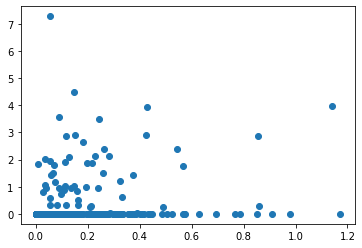

In [60]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()


OBSERVATION_NOISE = False
dataset = GaussianProcessRandomDataset(
    dimension=5, n_datapoints=20, observation_noise=OBSERVATION_NOISE,
    device=device)

n_samples = 1000

ei_values = torch.empty(n_samples, device=device)
improvement_values = torch.empty(n_samples, device=device)


with torch.no_grad():
    for i in range(n_samples):
        x_values, y_values, random_model = next(dataset)

        # x_values is shape (n_datapoints, dimension)
        # y_values is shape (n_datapoints,)
        x_hist = x_values[:-1, :]
        y_hist = y_values[:-1]
        x = x_values[-1:, :]
        y = y_values[-1:]
        
        ei_value, improvement_value = calculate_EI_GP(random_model, x_hist, y_hist, x, y, fit_params=False)
        ei_values[i] = ei_value[0]
        improvement_values[i] = improvement_value[0]

    # print(ei_values)
    # print(improvement_values)


# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

plt.scatter(ei_values.cpu().numpy(), improvement_values.cpu().numpy())

In [61]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        assert end > start, "this example code only works with end >= start"
        self.start = start
        self.end = end

    def __iter__(self):
        return iter(range(self.start, self.end))

for x in MyIterableDataset(3, 7):
    print(x)


3
4
5
6


In [62]:
u = torch.rand(8, 3)
print(u)
rand_indices = torch.randperm(u.shape[0])
print(rand_indices)
print(u[rand_indices])
print(u[rand_indices[:3]])
print(u[rand_indices[3:]])

tensor([[0.7216, 0.5588, 0.0163],
        [0.2358, 0.4761, 0.7996],
        [0.8445, 0.7417, 0.1469],
        [0.1755, 0.5438, 0.9176],
        [0.1534, 0.6505, 0.3717],
        [0.8424, 0.6213, 0.9883],
        [0.7804, 0.5583, 0.8764],
        [0.3487, 0.1458, 0.6460]])
tensor([2, 4, 0, 6, 7, 1, 3, 5])
tensor([[0.8445, 0.7417, 0.1469],
        [0.1534, 0.6505, 0.3717],
        [0.7216, 0.5588, 0.0163],
        [0.7804, 0.5583, 0.8764],
        [0.3487, 0.1458, 0.6460],
        [0.2358, 0.4761, 0.7996],
        [0.1755, 0.5438, 0.9176],
        [0.8424, 0.6213, 0.9883]])
tensor([[0.8445, 0.7417, 0.1469],
        [0.1534, 0.6505, 0.3717],
        [0.7216, 0.5588, 0.0163]])
tensor([[0.7804, 0.5583, 0.8764],
        [0.3487, 0.1458, 0.6460],
        [0.2358, 0.4761, 0.7996],
        [0.1755, 0.5438, 0.9176],
        [0.8424, 0.6213, 0.9883]])


In [63]:
q = torch.rand(20)
q - 10.0

tensor([-9.4122, -9.7531, -9.2286, -9.5989, -9.1321, -9.4680, -9.3031, -9.7429,
        -9.3805, -9.6507, -9.0406, -9.3168, -9.1272, -9.9820, -9.1291, -9.4314,
        -9.7203, -9.4293, -9.0302, -9.4230])

In [64]:
list[dict]

list[dict]

In [65]:
{x:y for x, y in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([0.]),
 'mean_module.raw_constant': Parameter containing:
 tensor(0., requires_grad=True),
 'covar_module.raw_outputscale': Parameter containing:
 tensor(0., requires_grad=True),
 'covar_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[0.]], requires_grad=True)}

In [66]:
{x:y.detach() for x, y in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': tensor([0.]),
 'mean_module.raw_constant': tensor(0.),
 'covar_module.raw_outputscale': tensor(0.),
 'covar_module.base_kernel.raw_lengthscale': tensor([[0.]])}

In [67]:
model.index

0

In [68]:
fixed_dataset = ListMapFunctionSamplesDataset.from_iterable_dataset(dataset, 1000)
fixed_dataset.save("data")

Saving realizations from GaussianProcessRandomDataset into ListMapFunctionSamplesDataset


100%|██████████| 1000/1000 [00:04<00:00, 237.86it/s]


In [69]:
fixed_dataset[0][0]

tensor([[2.3770e-01, 5.9728e-01, 1.3027e-01, 8.7175e-01, 1.3623e-01],
        [2.8008e-01, 5.2939e-01, 7.4921e-01, 6.7475e-01, 7.0635e-01],
        [3.8596e-04, 1.7254e-01, 9.1312e-01, 5.6526e-01, 8.1478e-01],
        [4.3732e-01, 4.3083e-01, 3.0867e-01, 7.7489e-01, 8.4643e-01],
        [6.1417e-01, 7.0303e-01, 8.9406e-02, 6.5903e-01, 9.4700e-01],
        [1.3595e-01, 2.9692e-01, 8.0865e-01, 3.6557e-01, 8.0262e-02],
        [5.5435e-01, 2.0977e-01, 9.9751e-01, 2.5552e-01, 2.0415e-01],
        [9.2425e-01, 4.8544e-01, 7.1970e-01, 3.0899e-01, 4.5466e-02],
        [4.7055e-01, 6.2878e-01, 3.4137e-01, 1.5561e-01, 2.4682e-01],
        [5.0904e-01, 5.2614e-01, 5.8093e-01, 3.4311e-02, 5.9625e-01],
        [2.4432e-02, 3.5175e-01, 1.1442e-01, 4.1488e-01, 2.4443e-01],
        [1.9026e-01, 5.0099e-01, 8.4974e-01, 9.3262e-01, 9.7229e-01],
        [6.5269e-01, 1.5853e-01, 5.4473e-01, 3.1906e-01, 5.2323e-01],
        [3.3650e-01, 5.1750e-01, 7.4551e-01, 5.5767e-01, 2.9194e-01],
        [9.8836e-01,

In [70]:
fixed_dataset_loaded = ListMapFunctionSamplesDataset.load("data")
fixed_dataset_loaded[0][2].index

0

In [2]:
# test_dataset = ListMapFunctionSamplesDataset([
#     ([i], [i]) for i in range(20)
# ] + [([12, 13], [33], SingleTaskGP(torch.zeros(2, 1), torch.zeros(2, 1), likelihood=likelihood, covar_module=kernel))])

test_dataset = ListMapFunctionSamplesDataset([
    ([i], [i]) for i in range(20)
] + [([12, 13], [33])])

# test_dataset = ListMapFunctionSamplesDataset(
#     [([12, 13], [33])])

# test_dataset = GaussianProcessRandomDataset(
#     dimension=2, n_datapoints=4, observation_noise=OBSERVATION_NOISE,
#     device=device)


data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,
                                        #   sampler=torch.utils.data.RandomSampler(test_dataset, replacement=False, num_samples=200)
                                          )

for x in test_dataset:
    print(x, type(x))




FunctionSamplesItem([0], [0]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([1], [1]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([2], [2]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([3], [3]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([4], [4]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([5], [5]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([6], [6]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([7], [7]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([8], [8]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([9], [9]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([10], [10]) <class 'function_samples_dataset.FunctionSamplesItem'>
FunctionSamplesItem([11], [11]) <class 'function_samples_datase

In [72]:
hasattr(test_dataset, '_model_sampler')
 # "Generating GP realizations:"

True

In [73]:
rand_dataset = GaussianProcessRandomDataset(n_datapoints=15, dimension=5, dataset_size=94)
function_samples_dataset = ListMapFunctionSamplesDataset.from_iterable_dataset(rand_dataset, 123)
function_samples_dataset = function_samples_dataset[:20]
function_samples_dataset.save('fixed', 17)
rand_dataset.save('random')
loaded_dataset = ListMapFunctionSamplesDataset.load('fixed')
print(len(loaded_dataset))

Saving realizations from GaussianProcessRandomDataset into ListMapFunctionSamplesDataset


  0%|          | 0/123 [00:00<?, ?it/s]

100%|██████████| 123/123 [00:00<00:00, 291.53it/s]


Generating and saving realizations from GaussianProcessRandomDataset


100%|██████████| 94/94 [00:00<00:00, 285.27it/s]

17


In [74]:
len(function_samples_dataset), len(loaded_dataset)

(20, 17)

In [13]:
import math
from utils import int_linspace
from tictoc import tic, toc

n_prints = 27

tic()
for k in range(1):
    for n_iter in range(1, 100+1):
        # every_n = math.ceil(n_iter / n_prints)
        # nums = [x for x in range(n_iter) if x % every_n == 0]
        
        nums = int_linspace(0, n_iter-1, min(n_prints, n_iter))
        print(set(nums))

        actual_n_prints = len(nums)
        
        print(f'{n_iter} batches:, want {n_prints} prints, got {actual_n_prints} prints')
        print(nums)
        print()
toc()

# tic()
# for k in range(10_000):
#     n_iter = 6700000
#     nums = int_linspace(0, n_iter-1, min(n_prints, n_iter))
# toc()

{0}
1 batches:, want 27 prints, got 1 prints
[0]

{0, 1}
2 batches:, want 27 prints, got 2 prints
[0 1]

{0, 1, 2}
3 batches:, want 27 prints, got 3 prints
[0 1 2]

{0, 1, 2, 3}
4 batches:, want 27 prints, got 4 prints
[0 1 2 3]

{0, 1, 2, 3, 4}
5 batches:, want 27 prints, got 5 prints
[0 1 2 3 4]

{0, 1, 2, 3, 4, 5}
6 batches:, want 27 prints, got 6 prints
[0 1 2 3 4 5]

{0, 1, 2, 3, 4, 5, 6}
7 batches:, want 27 prints, got 7 prints
[0 1 2 3 4 5 6]

{0, 1, 2, 3, 4, 5, 6, 7}
8 batches:, want 27 prints, got 8 prints
[0 1 2 3 4 5 6 7]

{0, 1, 2, 3, 4, 5, 6, 7, 8}
9 batches:, want 27 prints, got 9 prints
[0 1 2 3 4 5 6 7 8]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
10 batches:, want 27 prints, got 10 prints
[0 1 2 3 4 5 6 7 8 9]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
11 batches:, want 27 prints, got 11 prints
[ 0  1  2  3  4  5  6  7  8  9 10]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
12 batches:, want 27 prints, got 12 prints
[ 0  1  2  3  4  5  6  7  8  9 10 11]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,

In [75]:
for (x1,y1,z1), (x2,y2,z2) in zip(loaded_dataset, function_samples_dataset):
    assert torch.allclose(x1, x2)
    assert torch.allclose(y1, y2)

In [76]:
function_samples_dataset_2 = ListMapFunctionSamplesDataset.from_iterable_dataset(rand_dataset, 100)

Saving realizations from GaussianProcessRandomDataset into ListMapFunctionSamplesDataset


100%|██████████| 100/100 [00:00<00:00, 191.19it/s]


In [77]:
loaded_dataset[0][2]

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(0.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

In [78]:
function_samples_dataset_2[0][2]

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(0.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

In [79]:
from collections.abc import Sequence
import numpy as np
print(isinstance([1, 2, 3], Sequence))
print(isinstance((1,2,3), Sequence))
print(isinstance(np.array([1,5,5]), Sequence))

True
True
False


In [80]:
len(np.array([1,5,5]))

3

In [81]:
np.array([1,5,5])[0]

1

In [82]:
import torch
int(torch.distributions.Binomial(10, 0.5).sample())

4

In [83]:
from function_samples_dataset import GaussianProcessRandomDataset, ListMapFunctionSamplesDataset
from acquisition_dataset import FunctionSamplesAcquisitionDataset

N_CANDIDATES = 12
MAX_HISTORY = 30
HISTORY_LOGUNIFORM = True

if HISTORY_LOGUNIFORM:
    randint_gen = get_loguniform_randint_generator(
        1, MAX_HISTORY, pre_offset=3.0, offset=N_CANDIDATES)
else:
    randint_gen = get_uniform_randint_generator(
        N_CANDIDATES+1, N_CANDIDATES+MAX_HISTORY)

dataset = GaussianProcessRandomDataset(
    dimension=6, n_datapoints_random_gen=randint_gen, observation_noise=False,
    device=device, dataset_size=20)
dataset = ListMapFunctionSamplesDataset.from_iterable_dataset(dataset, 10)

aq_dataset = FunctionSamplesAcquisitionDataset(
    dataset, n_candidate_points=N_CANDIDATES, n_samples="all", give_improvements=True, min_n_candidates=2, dataset_size_factor=3)

train_aq_dataset, test_aq_dataset = aq_dataset.random_split([0.8, 0.2])

print("dataset:")
for x, y, model in dataset:
    print(x.shape, y.shape)
    # print(list(model.named_parameters()))
print()

print("aq_dataset:")
for x_hist, y_hist, x_cand, improvements, model in aq_dataset:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)
print()

print("train_aq_dataset:")
for x_hist, y_hist, x_cand, improvements, model in train_aq_dataset:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)
print()

print("test_aq_dataset:")
for x_hist, y_hist, x_cand, improvements, model in test_aq_dataset:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)
print()

print(list(dataset.model_sampler.initial_models[0].named_parameters()))


Saving realizations from GaussianProcessRandomDataset into ListMapFunctionSamplesDataset


100%|██████████| 10/10 [00:00<00:00, 151.74it/s]

dataset:
torch.Size([20, 6]) torch.Size([20])
torch.Size([13, 6]) torch.Size([13])
torch.Size([18, 6]) torch.Size([18])
torch.Size([38, 6]) torch.Size([38])
torch.Size([19, 6]) torch.Size([19])
torch.Size([40, 6]) torch.Size([40])
torch.Size([13, 6]) torch.Size([13])
torch.Size([15, 6]) torch.Size([15])
torch.Size([31, 6]) torch.Size([31])
torch.Size([13, 6]) torch.Size([13])

aq_dataset:
torch.Size([1, 6]) torch.Size([1]) torch.Size([12, 6]) torch.Size([12])
torch.Size([26, 6]) torch.Size([26]) torch.Size([12, 6]) torch.Size([12])
torch.Size([28, 6]) torch.Size([28]) torch.Size([12, 6]) torch.Size([12])
torch.Size([1, 6]) torch.Size([1]) torch.Size([12, 6]) torch.Size([12])
torch.Size([1, 6]) torch.Size([1]) torch.Size([12, 6]) torch.Size([12])
torch.Size([3, 6]) torch.Size([3]) torch.Size([12, 6]) torch.Size([12])
torch.Size([8, 6]) torch.Size([8]) torch.Size([12, 6]) torch.Size([12])
torch.Size([19, 6]) torch.Size([19]) torch.Size([12, 6]) torch.Size([12])
torch.Size([6, 6]) torch.S

 torch.Size([12, 6]) torch.Size([12])
torch.Size([1, 6]) torch.Size([1]) torch.Size([12, 6]) torch.Size([12])
torch.Size([26, 6]) torch.Size([26]) torch.Size([12, 6]) torch.Size([12])
torch.Size([7, 6]) torch.Size([7]) torch.Size([12, 6]) torch.Size([12])
torch.Size([28, 6]) torch.Size([28]) torch.Size([12, 6]) torch.Size([12])
torch.Size([1, 6]) torch.Size([1]) torch.Size([12, 6]) torch.Size([12])
torch.Size([3, 6]) torch.Size([3]) torch.Size([12, 6]) torch.Size([12])
torch.Size([6, 6]) torch.Size([6]) torch.Size([12, 6]) torch.Size([12])
torch.Size([19, 6]) torch.Size([19]) torch.Size([12, 6]) torch.Size([12])
torch.Size([8, 6]) torch.Size([8]) torch.Size([12, 6]) torch.Size([12])
torch.Size([1, 6]) torch.Size([1]) torch.Size([12, 6]) torch.Size([12])

train_aq_dataset:
torch.Size([8, 6]) torch.Size([8]) torch.Size([12, 6]) torch.Size([12])
torch.Size([3, 6]) torch.Size([3]) torch.Size([12, 6]) torch.Size([12])
torch.Size([26, 6]) torch.Size([26]) torch.Size([12, 6]) torch.Size([12])

In [84]:
from function_samples_dataset import FunctionSamplesDataset
from torch.utils.data import IterableDataset

dataset = GaussianProcessRandomDataset(
    dimension=6, n_datapoints_random_gen=randint_gen, observation_noise=False,
    device=device, dataset_size=20)
print(isinstance(dataset, FunctionSamplesDataset), isinstance(dataset, IterableDataset))
dataset = ListMapFunctionSamplesDataset.from_iterable_dataset(dataset)

dataset = dataset[:-3]

# v = iter(dataset)
# for _ in range(2):
#     print(next(v))

train_dataset, test_dataset = dataset.random_split([0.8, 0.2])
print(type(train_dataset))
train_subset_1, train_subset_2 = train_dataset.random_split([0.8, 0.2])
print(type(train_subset_1), len(train_subset_1))
# train_subset_1 = train_subset_1[:4]
# print(type(train_subset_1), len(train_subset_1))
train_subset_1.save('train')
loaded_train = ListMapFunctionSamplesDataset.load('train')
for x, y, model in loaded_train:
    print(x.shape, y.shape)
    print(list(model.named_parameters()))
    print()

print(len(dataset), len(train_dataset), len(loaded_train), len(train_subset_1))

print('\n')

aq1 = FunctionSamplesAcquisitionDataset(
    train_subset_1, n_candidate_points=N_CANDIDATES, n_samples="all", give_improvements=True, min_n_candidates=2, dataset_size_factor=1)
dataloader = aq1.get_dataloader(batch_size=3, drop_last=True)
for x_hist, y_hist, x_cand, vals_cand, hist_mask, cand_mask, models in dataloader:
    print(x_hist.shape, y_hist.shape, x_cand.shape, vals_cand.shape,
          hist_mask if hist_mask is None else hist_mask.shape,
          cand_mask if cand_mask is None else cand_mask.shape)
    print([type(model) for model in models])
    print()



# aq_dataset = FunctionSamplesAcquisitionDataset(
#     dataset, n_candidate_points=N_CANDIDATES, n_samples="all", give_improvements=True, min_n_candidates=2)
# v = iter(aq_dataset)
# for _ in range(2):
#     print(next(v))
# train_aq_dataset, test_aq_dataset = aq_dataset.random_split([20, 10])

True True
Saving realizations from GaussianProcessRandomDataset into ListMapFunctionSamplesDataset


100%|██████████| 20/20 [00:00<00:00, 150.70it/s]

<class 'dataset_with_models.MapFunctionSamplesSubset'>
<class 'dataset_with_models.MapFunctionSamplesSubset'> 12
torch.Size([14, 6]) torch.Size([14])
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.])), ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(5.0183, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-0.5937, -0.7234, -0.7051, -0.3100,  0.2769, -0.5216]],
       requires_grad=True))]

torch.Size([13, 6]) torch.Size([13])
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.])), ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(24.7716, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-0.3166,  0.5050, -0.4871, -0.4972,  0.1745,  0.8940]],
       requires_

 torch.Size([16])
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.])), ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(5.5066, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-0.6178, -1.3973, -0.9966,  0.0687, -0.8019, -0.7827]],
       requires_grad=True))]

torch.Size([29, 6]) torch.Size([29])
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.])), ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(19.7305, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-1.3467, -3.4180, -0.4457,  0.0798,  0.7735, -2.3735]],
       requires_grad=True))]

torch.Size([39, 6]) torch.Size([39])
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.])), ('mean

In [85]:
dataset = GaussianProcessRandomDataset(
    dimension=6, n_datapoints_random_gen=randint_gen, observation_noise=False,
    device=device, dataset_size=None)
v = iter(dataset)
v

In [86]:
import torch
import torch.nn as nn

# Dimensions
N = 10  # Number of y_i vectors
d = 20  # Dimension of x
p = 30  # Dimension of output
m = 256  # Dimension of y_i

# Example inputs
x = torch.randn(d, 1, requires_grad=True)  # (d, 1)
y = torch.randn(m, N, requires_grad=True)  # (m, N)

# Define the linear layers
linear_layer_a = nn.Linear(d + m, p)
linear_layer_x = nn.Linear(d, p)
linear_layer_y = nn.Linear(m, p, bias=False)

# Manually set the weights and biases to ensure they are the same
with torch.no_grad():
    # Combine weights and biases for the linear layer in Approach (a)
    combined_weight = torch.cat((linear_layer_x.weight, linear_layer_y.weight), dim=1)
    linear_layer_a.weight.copy_(combined_weight)
    linear_layer_a.bias.copy_(linear_layer_x.bias)

# Approach (a): Stacking and Applying a Single Linear Layer
x_repeated = x.t().repeat(N, 1)  # (N, d)
input_matrix = torch.cat((x_repeated, y.t()), dim=1)  # (N, d + m)
output_a = linear_layer_a(input_matrix)  # (N, p)
output_a.sum().backward()
grad_x_a = x.grad.clone()
grad_y_a = y.grad.clone()

# Reset gradients
x.grad.zero_()
y.grad.zero_()

# Approach (b): Separate Linear Layers and Summing Results
output_x = linear_layer_x(x.t()).repeat(N, 1)  # (N, p)
output_y = linear_layer_y(y.t())  # (N, p)
output_b = output_x + output_y  # (N, p)
output_b.sum().backward()
grad_x_b = x.grad.clone()
grad_y_b = y.grad.clone()

# Compare gradients
print("Gradient w.r.t x (Approach a):", grad_x_a)
print("Gradient w.r.t x (Approach b):", grad_x_b)
print("Gradients w.r.t x are equal:", torch.allclose(grad_x_a, grad_x_b, atol=1e-6))

print("Gradient w.r.t y (Approach a):", grad_y_a)
print("Gradient w.r.t y (Approach b):", grad_y_b)
print("Gradients w.r.t y are equal:", torch.allclose(grad_y_a, grad_y_b, atol=1e-6))


Gradient w.r.t x (Approach a): tensor([[ -2.6150],
        [  1.7125],
        [ -4.0522],
        [  6.5352],
        [  3.1333],
        [  5.3518],
        [  1.9289],
        [  2.5856],
        [  8.3773],
        [ -1.6640],
        [  7.7785],
        [ -0.3526],
        [  2.6515],
        [ 12.2907],
        [ -0.9190],
        [-10.1967],
        [ -2.0980],
        [ -7.7207],
        [ -3.3018],
        [ -2.8200]])
Gradient w.r.t x (Approach b): tensor([[ -2.6150],
        [  1.7125],
        [ -4.0522],
        [  6.5352],
        [  3.1333],
        [  5.3518],
        [  1.9289],
        [  2.5856],
        [  8.3773],
        [ -1.6640],
        [  7.7785],
        [ -0.3526],
        [  2.6515],
        [ 12.2907],
        [ -0.9190],
        [-10.1967],
        [ -2.0980],
        [ -7.7207],
        [ -3.3018],
        [ -2.8200]])
Gradients w.r.t x are equal: True
Gradient w.r.t y (Approach a): tensor([[ 0.0339,  0.0339,  0.0339,  ...,  0.0339,  0.0339,  0.0339],
 

In [87]:
from torch.masked import masked_tensor

data = torch.arange(24).reshape(2, 3, 4).float()
mask = data % 2 == 0

print("data:\n", data)
print(f"mask: {mask.dtype}\n", mask)
mt = masked_tensor(data, mask)
print("data masked:\n", mt)

data2 = torch.randn(2, 3, 4)
mt2 = masked_tensor(data2, mask)
print("data2 masked:\n", mt2)

stacked_masked = torch.vstack([mt, mt2])
print("stacked_masked:\n", stacked_masked)


data:
 tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]],

        [[12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.]]], dtype=torch.float32)
mask: torch.bool
 tensor([[[ True, False,  True, False],
         [ True, False,  True, False],
         [ True, False,  True, False]],

        [[ True, False,  True, False],
         [ True, False,  True, False],
         [ True, False,  True, False]]])
data masked:
 MaskedTensor(
  [
    [
      [  0.0000,       --,   2.0000,       --],
      [  4.0000,       --,   6.0000,       --],
      [  8.0000,       --,  10.0000,       --]
    ],
    [
      [ 12.0000,       --,  14.0000,       --],
      [ 16.0000,       --,  18.0000,       --],
      [ 20.0000,       --,  22.0000,       --]
    ]
  ]
)
data2 masked:
 MaskedTensor(
  [
    [
      [ -0.9267,       --,   1.0549,       --],
      [ -0.8802,       --,  -0.8436,       --],
      [  0.0279,       --,   2.4026,      

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


(array([ 43.,   0.,   0.,   0.,   0.,   0.,  35.,   0.,   0.,   0.,  31.,
          0.,   0.,  36.,   0.,  30.,   0.,  36.,   0.,  38.,  36.,  44.,
         37.,  28.,  23.,  59.,  39.,  69.,  71.,  67.,  77., 106.,  66.,
        106., 144., 149., 130., 136., 198., 145., 243., 230., 236., 285.,
        289., 381., 376., 404., 513., 531., 587., 625., 717., 777., 863.,
        964.]),
 array([0.        , 0.10185326, 0.20370652, 0.30555978, 0.40741303,
        0.50926629, 0.61111955, 0.71297281, 0.81482607, 0.91667933,
        1.01853258, 1.12038584, 1.2222391 , 1.32409236, 1.42594562,
        1.52779888, 1.62965214, 1.73150539, 1.83335865, 1.93521191,
        2.03706517, 2.13891843, 2.24077169, 2.34262494, 2.4444782 ,
        2.54633146, 2.64818472, 2.75003798, 2.85189124, 2.9537445 ,
        3.05559775, 3.15745101, 3.25930427, 3.36115753, 3.46301079,
        3.56486405, 3.66671731, 3.76857056, 3.87042382, 3.97227708,
        4.07413034, 4.1759836 , 4.27783686, 4.37969011, 4.48154337,
  

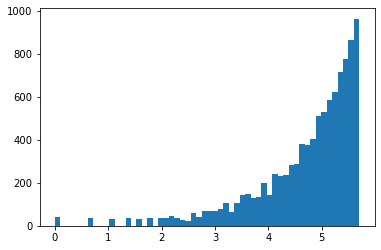

In [88]:
min_val = 1
max_val = 300
vals = torch.randint(min_val, max_val+1, (10_000,), dtype=torch.float64)

data = torch.log(vals).numpy()
plt.hist(data, bins='auto')

In [89]:

vals = loguniform_randint(1, 1000, 1000, pre_offset=15.0)
print(vals)

# fig = plt.figure()
# ax = fig.add_subplot(2, 1, 1)
# ax.hist(vals.numpy(), bins=500)
# ax.set_xscale('log')

tensor([479,  61, 736, 798,  30, 101,   1, 207, 625,  55, 805,   2, 456, 702,
        554, 463, 154,  42,  80,  63, 324, 101,  34,  31, 401,  58, 893, 635,
        533,  19, 598, 977, 753,  74, 293,  14, 125, 583,  10, 754,  15, 326,
          5, 111, 422,  43,  80, 139, 185, 349, 108,  42,  37, 765, 146, 121,
          2,  57,  34,  19,  22,  36,  63, 365,  21,  13, 911,  31, 913,  36,
         17,  14, 299,   5,   7,  52,   6,  93,  50,  28,  31,   6, 168,  39,
         10, 405,   6, 133,  79,  24,   6,  98,  12, 202, 736,   8, 238, 179,
         19, 130, 193,  66, 371, 167, 484, 162, 935,  11,  20, 145,  17,  99,
          3, 177,  10, 776,  94, 524, 266, 316,  51,  45,  33,  20, 133,   2,
        845, 219,   9,  61, 353,  28,   9,  70, 187, 409, 740, 638,  28,  18,
        191,  35, 148, 618, 394,  70, 381,   5, 411, 394,   1,  31, 318, 237,
         39, 284, 312,  47, 158, 105,  44,  99, 133, 908,  39, 273, 134,  18,
          5, 716, 279, 115,  44,  46, 106,  53,  26, 646,  18, 9